Task - Classification
Aim
Multi-label classification with numerical variables (of your slice) of the Instacart dataset, predicting the product mix in the next order for a user.

Detail
The problem to solve takes the form of Classification with numerical independent variables.

Given the history of orders per user, Instacart would like to predict the mix of products that would be ordered next. From a business perspective, there is little to be gained from promoting a product that would be purchased in any case, but much to be gained from promoting a related product. Therefore, knowing the baseline (i.e., without marketing intervention) could improve the efficiency of product marketing efforts.

As with the regression task, we recommend that you choose a relevant subset of users for analysis, where relevant implies an unbiased subset chosen to make the problem tractable with the computing resources available to each student.

There are two subtasks that need to be considered:

taking historical order data from (a subset of) users and using this data to predict the next order for a typical user, given that user's order history
taking historical order data from a single user and using this data to predict the next order for that user.
The basic hypothesis in the first of these is that there is an underlying consistency across users in terms of their order behaviour, so the more data that is available, the better the prediction of a typical user's next order.

By contrast, the hypothesis in the second of these is that the order behaviour of different differs from each other, so it is better to tailor next order predictions to individual users.

We recommend the following three features (derived independent variables) for each product:

relative quantity across all orders for that user (computed as the number of times it is ordered divided by the number of all products ordered)
relative frequency of reorder (so if ordered twice in 4 orders, the reorder rate is (2-1)/(4-1) = 1/3). If not reordered, it takes the value 0.
(some function of) "add to cart order", across all orders for a given user. For example, if it was ordered 3 times, and was the first, third and fifth item added to these orders, the corresponding feature would take the mean value. Optionally, students might wish to investigate different ways of calculating this mean: the traditional arithmetic mean (3 in this case) or the harmonic mean (approximately 1.96 in this case) that gives more weight to smaller values.
The 3 features above are chosen in an attempt to capture the following predictive attributes:

how often a product is ordered, compared to all other products for that user
how frequently a product is reordered by a given user
using "add to cart order" as a proxy to represent the importance of the product to the user
Regarding feature 3, Kieran analysed the reorder rate as a function of "add to cart order" and found that it declined steadily as the "add to cart order" increased. This trend stopped abruptly at "add to cart order" 35 (approximately) when the relationship broke down, by exhibiting large oscillations.

Therefore, we recommend that you, as part of the Exploratory Data Analysis phase, plot reorder rate (across all relevant products and users) against "add to cart order", and use this to determine when the simple relationship breaks down, say at n=35.

You can then use linear regression to fit a low-order polynomial (linear or quadratic, say) to reorder rate as a function of "add to cart order" for the restricted range while the relationship shows a stable trend. Using the linear regression you learned, you should then be able to extrapolate a reorder rate for higher "add to cart order" values.

Indeed, it should be possible to use the results of this linear regression (and its extrapolation to higher "add to cart order" values) to lookup a generic reorder rate for a given (mean) "add to cart order" for a given product for a given user. This generic reorder rate can then be used in place of feature 3 above, as it is derived from the same data and represents much the same behaviour.

The dependent variable is the product mix in the next order for that user in the training set, expressed as a set of binary variables (0,1-valued: product is included or not).

The number of products could cause difficulties, because the number of features (hence columns in the observation matrix) is 3 times the number of products considered in the model, and the dependent variable is vector-valued, comprising indicator values for each of those products.

Therefore, you are recommended to limit your analysis as follows:

with multiple users, take the most popular 200 products, say
with a single user, limit to the products purchased by that user in their orders to date.
Regarding training, test data and validation, we recommend the following:

given order data from multiple users, the training data comprises all orders for an 80% subset of the relevant users. The learned classifier can then be applied to order data from the remaining 20% subset of users. For validation, you need to measure how well the classifer predicts the last order for those "test" users.
given order data from a single user, the training data for that user excludes the last order for that user. For testing, the learned classifier is applied to all the data including the last order and the product mix of the last order is predicted. For validation, the predicted last order can be compared with the actual last order for that user.
Disclaimers/Comments
Feature engineering is a very important part of this task, because Instacart does not provide labels as part of the data. Therefore, they need to be derived.

The classifiers covered in this module generally do not support as many options for dimensionality reduction as linear regression does, so depending on the scope of the learned classifier, we recommend either a user-specific product subset, or a "Top N" approach (of products purchased by the relevant users) in this task. Needless to say, it is essential to ensure that the same subset of products is used for features and for the vector-valued dependent variable.

One of the objectives in this task is to determine whether per-user or across-user models make better predictions. Therefore, you will need to compare the two model scopes and suggest which is more applicable to the Instacart data.

Multilabel classification, as used here (because the "product mix" dependent variable is vector-valued, taking a 1 or 0 in each product "slot" depending on whether the product is included or not), is most commonly used in document classification.

The relevant sklearn libraries for multilabel classification can be found here. For a text mining example, we might wish to label a book with multiple non-exclusive attributes, such as its theme, its genre, its intended audience, and whether it belongs to a series or not. When used for market basket analysis, as here, the main difficulty with multilabel classification is that the number of such labels (identifying products uniquely) can be enormous.

Grading Outline
25% deriving features 1 and 2 (will require data manipulation)
25% deriving feature 3 (will require solving a linear regression sub-problem)
20% choosing and using a classifier
30% validating the results, to include analysis of confusion matrix, precision, recall and between-model metrics such as F1-score etc.

# IMPORTS

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
sns.set_style("darkgrid")
sns.set_context("paper")

from itertools import combinations, groupby
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from sklearn import linear_model
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from collections import Counter
import sys

C:\Users\snolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# read the csvs

In [2]:
orders = pd.read_csv('instacart_2017_05_01/my_orders.csv',index_col=0)
products = pd.read_csv('instacart_2017_05_01/products.csv')
aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
orders_products_prior_full = pd.read_csv('instacart_2017_05_01/my_order_products__prior.csv',index_col=0)
orders_products_train_full = pd.read_csv('instacart_2017_05_01/my_order_products__train.csv',index_col=0)
orders_products = pd.concat([orders_products_prior_full, orders_products_train_full])

#build the master table 
order_products_orders = pd.merge(orders_products, orders, on="order_id")
order_products_products = pd.merge(order_products_orders, products, on="product_id")
order_products_aisles = pd.merge(order_products_products, aisles, on="aisle_id")
order_products_departments = pd.merge(order_products_aisles, departments, on="department_id")
order_products_departments.head()
order_products_master = order_products_departments.copy().set_index("order_id").sort_index()
order_products_master.head()

,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
order_id,,,,,,,,,,,,,,
8938,49235,1,1,179033,prior,17,3,10,12.0,Organic Half & Half,53,16,cream,dairy eggs
8938,15680,5,1,179033,prior,17,3,10,12.0,Red Plastic Cups,111,17,plates bowls cups flatware,household
8938,13032,2,1,179033,prior,17,3,10,12.0,Cinnamon Toast Crunch,121,14,cereal,breakfast
8938,9007,7,0,179033,prior,17,3,10,12.0,Frosted Flakes,121,14,cereal,breakfast
8938,26348,3,1,179033,prior,17,3,10,12.0,Mixed Fruit Fruit Snacks,50,19,fruit vegetable snacks,snacks


## Take sample user with id 1886
Find all the products they order
Count/Calculate how often they reorder each product
Calculate each products add to cart values 
- atc min is the most important this product has been (ie earliest its been added to the cart)
- atc max is the least important this product has been (ie latest its been added to the cart)
- atc mean is the average importance of this product (ie average placement in cart)

In [3]:
order_products_1886 = order_products_master.loc[order_products_master['user_id'] == 1886].sort_values(by="order_number")
df_group = order_products_1886.groupby("order_number")["order_number","product_name"]
order_count = order_products_1886["order_number"].nunique()
product_count = len(order_products_1886["product_name"])
unique_products = order_products_1886["product_name"].unique()
unique_product_count = len(unique_products)


add_to_cart_rows = []
for prod in unique_products:  
    row = {}
    data = order_products_master.loc[(order_products_master['user_id'] == 1886) & (order_products_master['product_name'] == prod)]
    row["product"] = prod
    row["atc_min"] = data["add_to_cart_order"].min()
    row["atc_mean"] = data["add_to_cart_order"].mean()
    row["atc_hmean"] = st.harmonic_mean(data["add_to_cart_order"].values)
    row["atc_max"] = data["add_to_cart_order"].max()
    add_to_cart_rows.append(row)

add_to_cart_df = pd.DataFrame(add_to_cart_rows, columns=add_to_cart_rows[0].keys())
    
product_list_master = []
for i in range(1, order_count+1):
     product_list_master.append(df_group.get_group(i)["product_name"].tolist())
        
#[item for sublist in l for item in sublist]
counter_map = Counter([item for sublist in product_list_master for item in sublist])
product_analysis = pd.DataFrame.from_dict(counter_map, orient='index').reset_index()
product_analysis.rename(columns={'index':'product', 0:'count'},inplace=True)
product_analysis = product_analysis.sort_values(by="count",ascending=False)
product_analysis["reorder_count"] = product_analysis["count"]-1
product_analysis["relative_quantity"] = product_analysis["count"]/product_count
product_analysis["relative_freq_of_reorder"] = product_analysis["reorder_count"]/order_count
print(len(product_analysis))
product_analysis = pd.merge(product_analysis, add_to_cart_df, on="product")
print(len(product_analysis))
product_analysis.head()

40
40


,product,count,reorder_count,relative_quantity,relative_freq_of_reorder,atc_min,atc_mean,atc_hmean,atc_max
0,Natural Pure Sparkling Water,25,24,0.176056,0.888889,1,1.960000,1.450677,5
1,Dha Omega 3 Reduced Fat 2% Milk,14,13,0.098592,0.481481,1,2.285714,1.787234,4
2,Grapefruit Sparkling Water,13,12,0.091549,0.444444,1,2.384615,1.964736,5
3,Organic Coconut Chia Granola,7,6,0.049296,0.222222,1,4.000000,2.800000,6
4,Bold Habanero BBQ Almonds,7,6,0.049296,0.222222,3,4.571429,4.304539,7


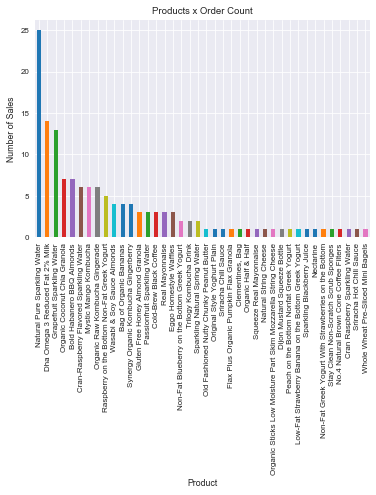

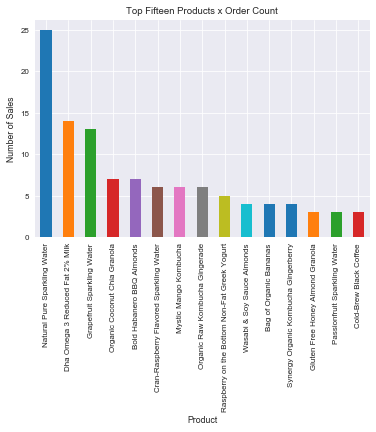

In [4]:
fig, ax = plt.subplots()
product_analysis['count'].plot.bar();
ax.set_xticklabels(product_analysis['product'])
plt.title("Products x Order Count")
plt.ylabel("Number of Sales")
plt.xlabel("Product")
plt.show()

fig, ax = plt.subplots()
product_analysis.head(n=15)['count'].plot.bar();
ax.set_xticklabels(product_analysis.head(n=15)['product'])
plt.title("Top Fifteen Products x Order Count")
plt.ylabel("Number of Sales")
plt.xlabel("Product")
plt.show()

plt.show()

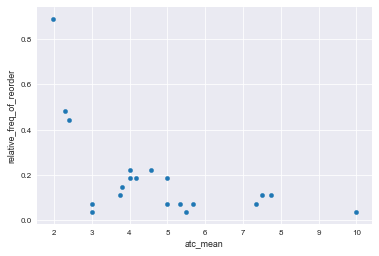

In [5]:

#only show items that have been reordered for this small sample set
data = product_analysis.loc[(product_analysis['reorder_count'] > 0)] 
data.plot(kind='scatter', x='atc_mean', y='relative_freq_of_reorder')

In [6]:
#https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

# plot add to cart position against probability of reordering
In the chart we should see that the more "important" a product (ie the sooner it is added to the cart), the higher the probability of that product being reordered

best fit line:
y = 0.46 + -0.06x


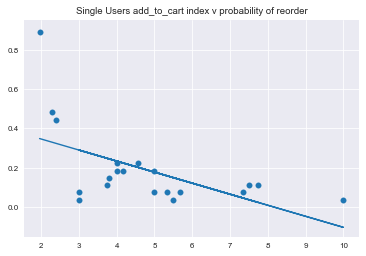

In [7]:
fig = plt.figure()
X = data["atc_mean"]
Y = data["relative_freq_of_reorder"]
a, b = best_fit(X, Y)

# plot points and fit line
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.title("Single Users add_to_cart index v probability of reorder")
plt.plot(X, yfit)

# Same analysis with all users
Find purchase frequency, probability of item being reordered and importance of items

In [8]:
c = order_products_master["product_id"].value_counts().gt(4) #4 returns top 100 (123/876)
top_hundred_products_df = order_products_master.loc[order_products_master["product_id"].isin(c[c].index)]
top_hundred_products = [item for item in top_hundred_products_df["product_name"].unique()]

order_products_all = order_products_master.copy().sort_values(by="order_number")
df_group = order_products_all.groupby("order_number")["order_number","product_name"]
order_count = order_products_all["order_number"].nunique()
product_count = len(order_products_all["product_name"])
unique_products = order_products_all["product_name"].unique()
unique_product_count = len(unique_products)


add_to_cart_rows = []
for prod in top_hundred_products:  
    row = {}
    data = order_products_master.loc[(order_products_master['product_name'] == prod)]
    row["product"] = prod
    row["atc_min"] = data["add_to_cart_order"].min()
    row["atc_mean"] = data["add_to_cart_order"].mean()
    #row["atc_hmean"] = st.harmonic_mean(data["add_to_cart_order"].values)
    row["atc_max"] = data["add_to_cart_order"].max()
    add_to_cart_rows.append(row)

add_to_cart_df = pd.DataFrame(add_to_cart_rows, columns=add_to_cart_rows[0].keys())
    
product_list_master = []
for i in range(1, order_count+1):
     product_list_master.append(df_group.get_group(i)["product_name"].tolist())
        
#[item for sublist in l for item in sublist]
counter_map = Counter([item for sublist in product_list_master for item in sublist])
product_analysis = pd.DataFrame.from_dict(counter_map, orient='index').reset_index()
product_analysis.rename(columns={'index':'product', 0:'count'},inplace=True)
product_analysis = product_analysis.sort_values(by="count",ascending=False)
product_analysis["reorder_count"] = product_analysis["count"]-1
product_analysis["relative_quantity"] = product_analysis["count"]/product_count
product_analysis["relative_freq_of_reorder"] = product_analysis["reorder_count"]/order_count
product_analysis = pd.merge(product_analysis, add_to_cart_df, on="product")
print("using top {} products".format(len(product_analysis))) #top 100 - 123 was the closest filter to 100 i could get
product_analysis.head()


using top 123 products


,product,count,reorder_count,relative_quantity,relative_freq_of_reorder,atc_min,atc_mean,atc_max
0,Banana,63,62,0.026537,1.265306,1,3.253968,14
1,Bag of Organic Bananas,31,30,0.013058,0.612245,1,4.096774,11
2,Natural Pure Sparkling Water,25,24,0.010531,0.489796,1,1.960000,5
3,Organic Half & Half,24,23,0.010110,0.469388,1,2.416667,7
4,Apple Honeycrisp Organic,23,22,0.009688,0.448980,1,4.478261,12


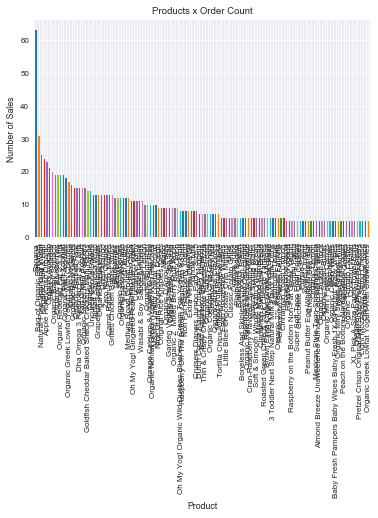

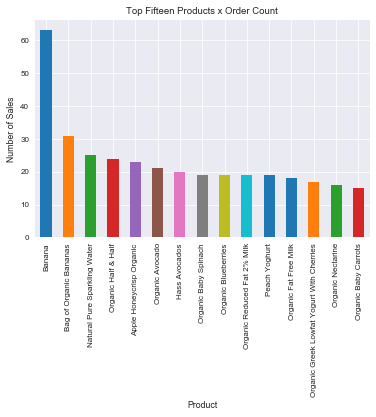

In [9]:
fig, ax = plt.subplots()
product_analysis['count'].plot.bar();
ax.set_xticklabels(product_analysis['product'])
plt.title("Products x Order Count")
plt.ylabel("Number of Sales")
plt.xlabel("Product")
plt.show()

fig, ax = plt.subplots()
product_analysis.head(n=15)['count'].plot.bar();
ax.set_xticklabels(product_analysis.head(n=15)['product'])
plt.title("Top Fifteen Products x Order Count")
plt.ylabel("Number of Sales")
plt.xlabel("Product")
plt.show()

plt.show()

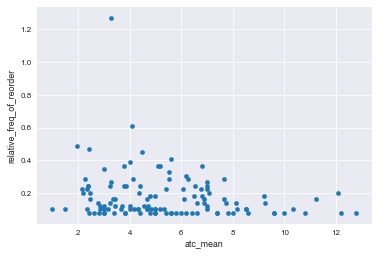

In [10]:

product_analysis.plot(kind='scatter', x='atc_mean', y='relative_freq_of_reorder')


## We can still see the relationship outlined in the single user analysis
The higher the item importance, the higher the probability of reordering

best fit line:
y = 0.24 + -0.01x


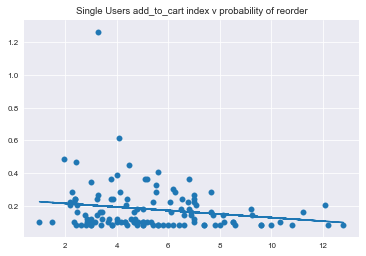

In [11]:
fig = plt.figure()
X = product_analysis["atc_mean"]
Y = product_analysis["relative_freq_of_reorder"]
a, b = best_fit(X, Y)

# plot points and fit line
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.title("Single Users add_to_cart index v probability of reorder")
plt.plot(X, yfit)